In [157]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

Загрузим данные и посмотрим первые значения в таблице.

In [158]:
data = pd.read_csv('./2015.csv')
data.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [159]:
data.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

Из фич для построении модели не нужны страна (из-за уникальности значений в каждой строке не может существовать зависимости между таргетом и этой фичей), рейтинг (произойдёт overfitting) и стандартная ошибка (влияет только на тестирование).
При этом остаётся только одна категориальная фича - регион.

In [160]:
num_cols = ['Economy (GDP per Capita)', 'Family',
    'Health (Life Expectancy)', 'Freedom',
    'Trust (Government Corruption)',
    'Generosity', 'Dystopia Residual']
cat_cols = ['Region']
target_col = 'Happiness Score'

cols = num_cols + cat_cols + [target_col]
data = data[cols]

Подгототовим данные для анализа.
Следующая ячейка показывает, что нет пропусков в данных.

In [161]:
data.isna().mean()

Economy (GDP per Capita)         0.0
Family                           0.0
Health (Life Expectancy)         0.0
Freedom                          0.0
Trust (Government Corruption)    0.0
Generosity                       0.0
Dystopia Residual                0.0
Region                           0.0
Happiness Score                  0.0
dtype: float64

Гистограммы и статистические данные показывают, что значимых выбросов в данных нет.

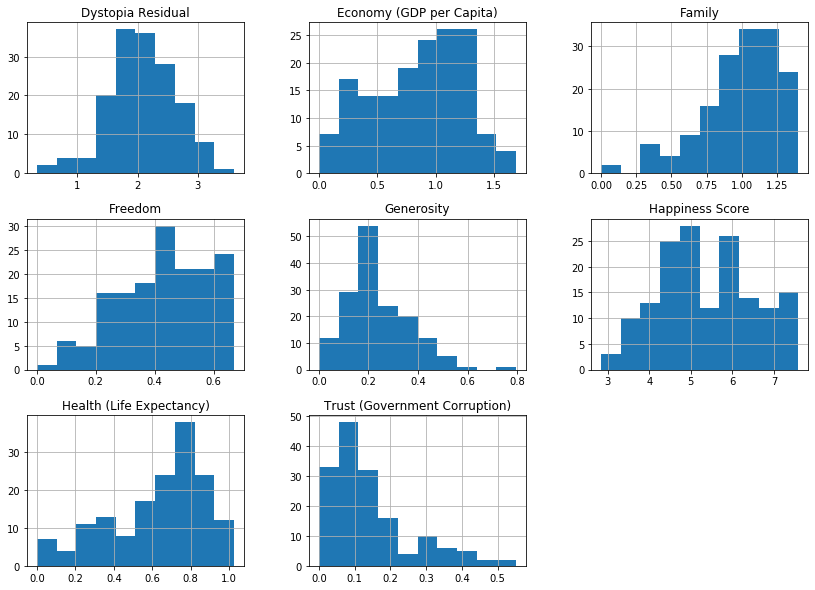

In [162]:
thist = data.hist(column=num_cols+cat_cols+[target_col], figsize=(14, 10))

In [163]:
data.describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Happiness Score
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977,5.375734
std,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550,1.145010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580,2.839000
25%,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410,4.526000
50%,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415,5.232500
75%,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415,6.243750
max,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140,7.587000


Теперь посмотрим на попарные корреляции всех полей. Как видно, наибольший вклад в индекс счастья вносят экономика, семья и здоровье, при этом самое незначительное влияние оказывает щедрость.

In [164]:
data.corr().style.background_gradient(cmap='Greys').set_precision(2)

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Happiness Score
Economy (GDP per Capita),1.00,0.65,0.82,0.37,0.31,-0.01,0.04,0.78
Family,0.65,1.00,0.53,0.44,0.21,0.09,0.15,0.74
Health (Life Expectancy),0.82,0.53,1.00,0.36,0.25,0.11,0.02,0.72
Freedom,0.37,0.44,0.36,1.00,0.49,0.37,0.06,0.57
Trust (Government Corruption),0.31,0.21,0.25,0.49,1.00,0.28,-0.03,0.40
Generosity,-0.01,0.09,0.11,0.37,0.28,1.00,-0.10,0.18
Dystopia Residual,0.04,0.15,0.02,0.06,-0.03,-0.10,1.00,0.53
Happiness Score,0.78,0.74,0.72,0.57,0.40,0.18,0.53,1.00


Матрица корреляций и попарные графики в следующей ячейке показывают, что у индекса счастья есть заметная зависимость от выбранных фич, которая, учитывая графики 'индекс счастья'-'экономика'/'семья'/'здоровье', близка к линейной.

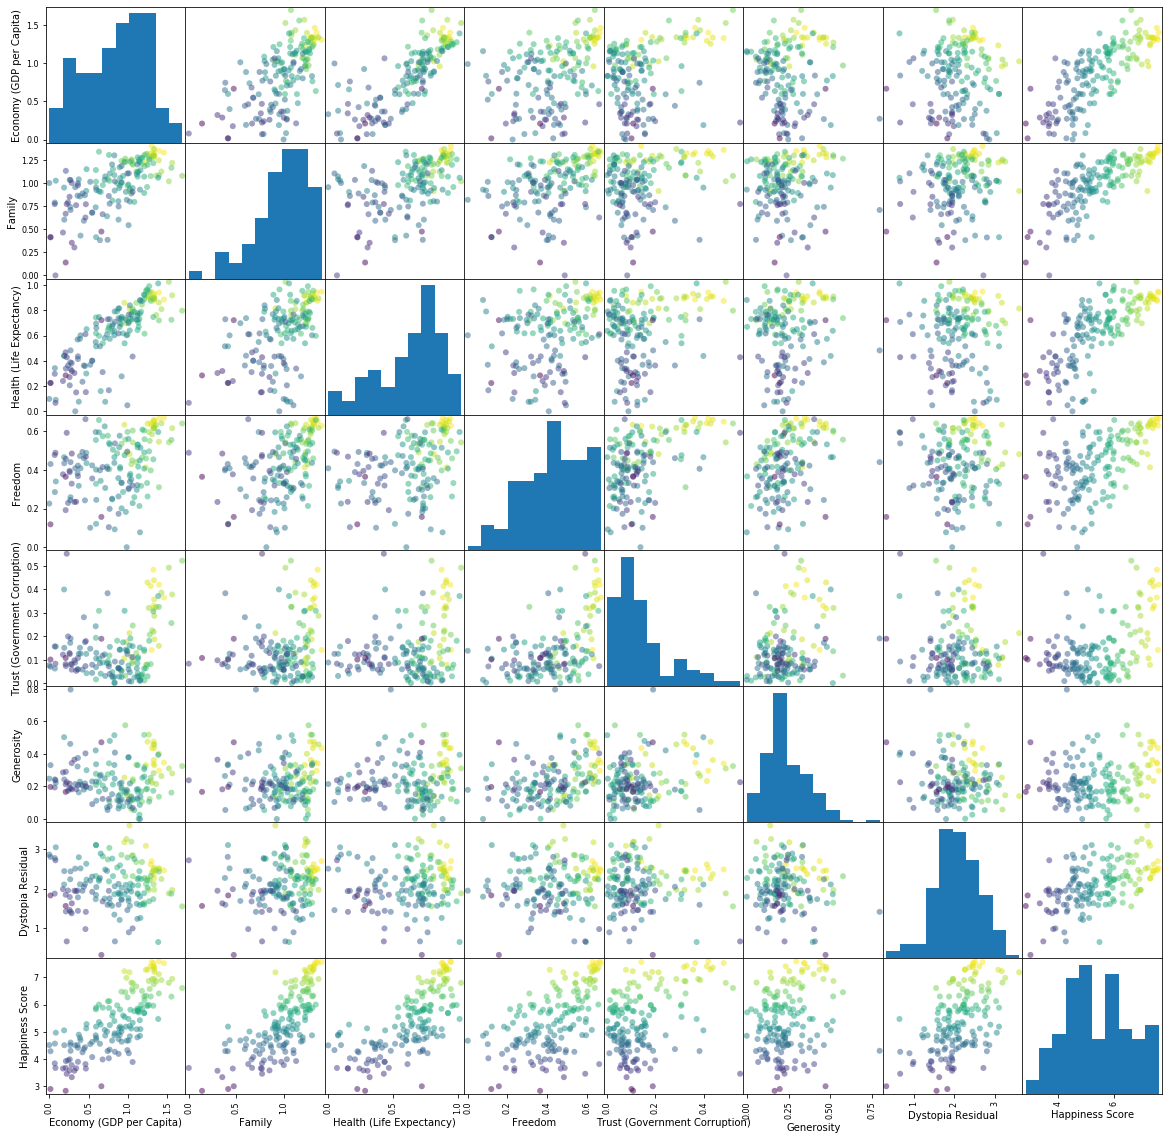

In [165]:
tplot = pd.plotting.scatter_matrix(data, c=data[target_col], figsize=(20, 20), marker='o')

Для работы алгоритмов регрессии sklearn переведём единственную категориальную фичу в числовую с помощью one-hot encoding.

In [166]:
data = pd.get_dummies(data, columns=cat_cols)
cat_cols = list(filter(lambda x: x.startswith('Region'), data.columns))

Уменьшим размерность таблицы, сохранив только 10 главных показателей.

In [167]:
X = PCA(n_components=10).fit_transform(data[num_cols + cat_cols])

Разобьём выборку на тренировочную и тестовую, определив для второй 40% данных.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, data[target_col], test_size=0.4)

In [169]:
def print_metrics(y_preds, y):
    print(f'R^2: {r2_score(y_preds, y)}')
    print(f'MSE: {mean_squared_error(y_preds, y)}')

Попробуем построить модель линейным регрессором.

In [170]:
lr = LinearRegression()
lr.fit(X_train, y_train)
None

Модель проявляет себя хорошо, причём R^2 близок к 1, значит большая доля вариации объясняется моделью.

In [171]:
y_pred = lr.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

MAE: 0.13009892174120324
MSE: 0.02850881600954431
R^2: 0.9740555120230393


Для сравнения можно посмотреть на результаты работы 2х других регрессоров (они справляются хуже).

In [172]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

MAE: 0.24716750436068372
MSE: 0.11258659723221773
R^2: 0.8975404093498559


In [173]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

MAE: 0.24712796875000015
MSE: 0.11893377059218745
R^2: 0.8917641553352981
